In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Load the dataset
df = pd.read_csv("positions_of_robot_and_human.csv")

# Display the first few rows
df.head()

,time,human_x,human_y,robot_x,robot_y
0,0,1.50,1.5,1.5,0.5
1,2,1.50,2.5,1.5,1.0
2,4,2.50,3.5,2.0,2.5
3,6,3.25,4.5,2.0,2.5
4,8,3.75,4.5,2.0,3.0


Average Distance: 187.21 cm
Maximum Distance: 278.10 cm
Time-Weighted Distance: 11449.84 cm·s


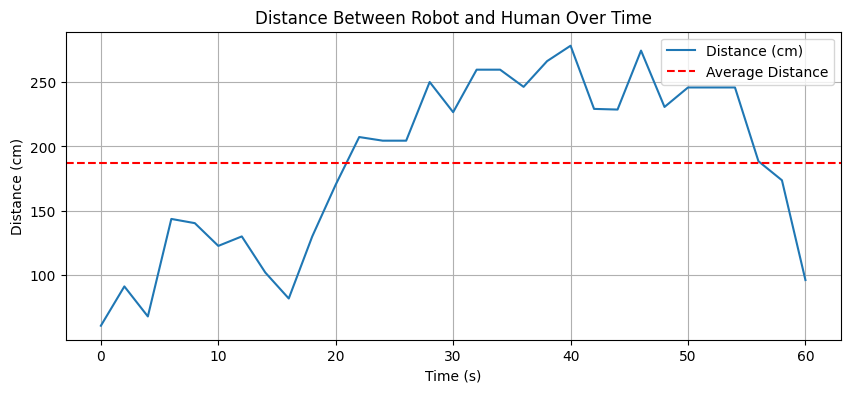

In [10]:
# Convert units to centimeters (1 unit = 2 ft = 60.96 cm)
UNIT_TO_CM = 60.96

# Calculate Euclidean distance in centimeters
df["distance_cm"] = np.sqrt(
    (df["robot_x"] - df["human_x"])**2 + 
    (df["robot_y"] - df["human_y"])**2
) * UNIT_TO_CM

# Metrics
avg_distance_cm = df["distance_cm"].mean()
max_distance_cm = df["distance_cm"].max()
time_weighted_distance_cm = np.trapz(df["distance_cm"], df["time"])  # Area under curve (cm·s)

print(f"Average Distance: {avg_distance_cm:.2f} cm")
print(f"Maximum Distance: {max_distance_cm:.2f} cm")
print(f"Time-Weighted Distance: {time_weighted_distance_cm:.2f} cm·s")

# Plot distance vs time
plt.figure(figsize=(10, 4))
plt.plot(df["time"], df["distance_cm"], label="Distance (cm)")
plt.axhline(avg_distance_cm, color="red", linestyle="--", label="Average Distance")
plt.xlabel("Time (s)")
plt.ylabel("Distance (cm)")
plt.title("Distance Between Robot and Human Over Time")
plt.legend()
plt.grid()
plt.show()

Optimal Time Lag: 0 frames (0.00 seconds)


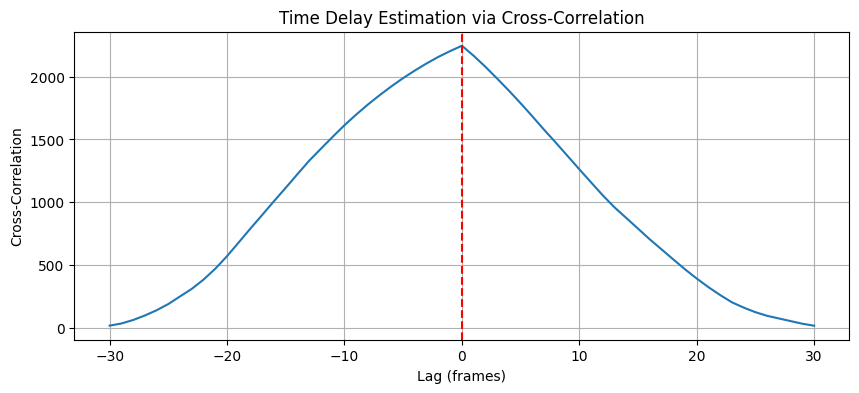

In [11]:
# Cross-correlation to find optimal time lag (Δt)
corr = correlate(df["human_x"], df["robot_x"], mode="full")
lag = np.arange(-(len(df) - 1), len(df))

# Find index of maximum correlation
optimal_lag_idx = np.argmax(corr)
optimal_lag = lag[optimal_lag_idx]
time_step = np.mean(np.diff(df["time"]))  # Time step in seconds
time_delay = optimal_lag * time_step  # Convert lag to seconds

print(f"Optimal Time Lag: {optimal_lag} frames ({time_delay:.2f} seconds)")

# Plot cross-correlation
plt.figure(figsize=(10, 4))
plt.plot(lag, corr)
plt.axvline(optimal_lag, color="red", linestyle="--")
plt.xlabel("Lag (frames)")
plt.ylabel("Cross-Correlation")
plt.title("Time Delay Estimation via Cross-Correlation")
plt.grid()
plt.show()

Average Acceleration: 220.46 cm/s²
Acceleration Variance (Jerkiness): 139.07


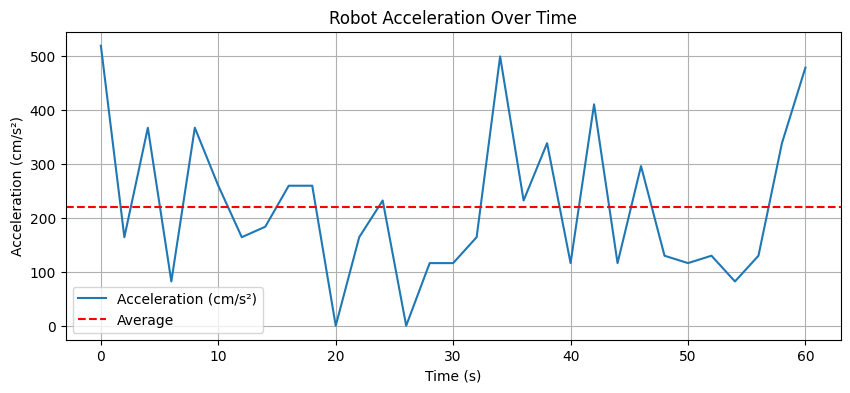

In [12]:
# Calculate velocity (in cm/s) and acceleration (in cm/s²)
time_step = np.mean(np.diff(df["time"]))  # Time step in seconds

# Convert velocity to cm/s (1 unit/s = 60.96 cm/s)
df["robot_vx"] = np.gradient(df["robot_x"], time_step) * UNIT_TO_CM
df["robot_vy"] = np.gradient(df["robot_y"], time_step) * UNIT_TO_CM

# Convert acceleration to cm/s² (1 unit/s² = 60.96 cm/s²)
df["robot_ax"] = np.gradient(df["robot_vx"], time_step) * UNIT_TO_CM
df["robot_ay"] = np.gradient(df["robot_vy"], time_step) * UNIT_TO_CM

# Magnitude of acceleration
df["acceleration"] = np.sqrt(df["robot_ax"]**2 + df["robot_ay"]**2)

# Metrics
avg_acceleration = df["acceleration"].mean()
jerkiness = df["acceleration"].std()

print(f"Average Acceleration: {avg_acceleration:.2f} cm/s²")
print(f"Acceleration Variance (Jerkiness): {jerkiness:.2f}")

# Plot acceleration
plt.figure(figsize=(10, 4))
plt.plot(df["time"], df["acceleration"], label="Acceleration (cm/s²)")
plt.axhline(avg_acceleration, color="red", linestyle="--", label="Average")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (cm/s²)")
plt.title("Robot Acceleration Over Time")
plt.legend()
plt.grid()
plt.show()

Human Path Length: 1283.62 cm
Robot Path Length: 1200.84 cm
Path Efficiency (Robot/Human): 0.94


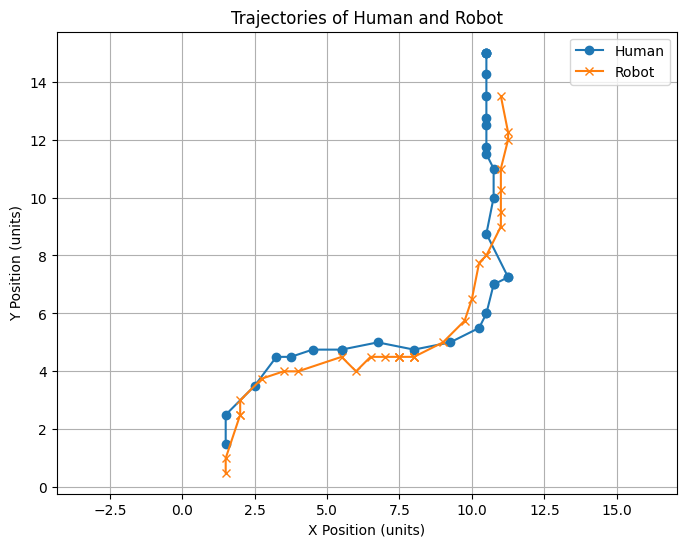

In [13]:
# Total path length for human and robot (in cm)
def path_length(x, y):
    return np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2)) * UNIT_TO_CM

human_path_cm = path_length(df["human_x"], df["human_y"])
robot_path_cm = path_length(df["robot_x"], df["robot_y"])
efficiency = robot_path_cm / human_path_cm

print(f"Human Path Length: {human_path_cm:.2f} cm")
print(f"Robot Path Length: {robot_path_cm:.2f} cm")
print(f"Path Efficiency (Robot/Human): {efficiency:.2f}")

# Plot trajectories
plt.figure(figsize=(8, 6))
plt.plot(df["human_x"], df["human_y"], label="Human", marker="o")
plt.plot(df["robot_x"], df["robot_y"], label="Robot", marker="x")
plt.xlabel("X Position (units)")
plt.ylabel("Y Position (units)")
plt.title("Trajectories of Human and Robot")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()

In [14]:
# Count near-collisions (distance < threshold in cm)
threshold_cm = 60.96  # Define safe distance threshold in cm (1 unit = 2 ft = 60.96 cm)
near_collisions = df[df["distance_cm"] < threshold_cm]

print(f"Number of Near-Collisions (<{threshold_cm} cm): {len(near_collisions)}")
print("Times of Near-Collisions:")
print(near_collisions[["time", "distance_cm"]])

Number of Near-Collisions (<60.96 cm): 0
Times of Near-Collisions:
Empty DataFrame
Columns: [time, distance_cm]
Index: []


Average Speed Error: 10.66 cm/s
Average Direction Error: 37.98°


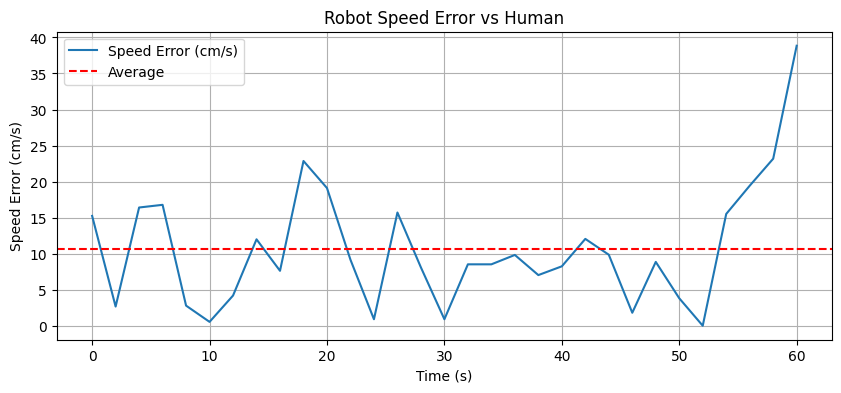

In [15]:
# Calculate velocity vectors in cm/s
df["human_vx"] = np.gradient(df["human_x"], time_step) * UNIT_TO_CM
df["human_vy"] = np.gradient(df["human_y"], time_step) * UNIT_TO_CM
df["robot_vx"] = np.gradient(df["robot_x"], time_step) * UNIT_TO_CM
df["robot_vy"] = np.gradient(df["robot_y"], time_step) * UNIT_TO_CM

# Speed error in cm/s
df["speed_error"] = np.abs(
    np.sqrt(df["robot_vx"]**2 + df["robot_vy"]**2) - 
    np.sqrt(df["human_vx"]**2 + df["human_vy"]**2)
)

# Direction alignment in degrees
dot_product = df["robot_vx"] * df["human_vx"] + df["robot_vy"] * df["human_vy"]
robot_speed = np.sqrt(df["robot_vx"]**2 + df["robot_vy"]**2)
human_speed = np.sqrt(df["human_vx"]**2 + df["human_vy"]**2)
cos_theta = dot_product / (robot_speed * human_speed + 1e-8)  # Avoid division by zero
df["angle"] = np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))  # Angle in degrees

# Metrics
avg_speed_error = df["speed_error"].mean()
avg_angle_error = df["angle"].mean()

print(f"Average Speed Error: {avg_speed_error:.2f} cm/s")
print(f"Average Direction Error: {avg_angle_error:.2f}°")

# Plot speed error
plt.figure(figsize=(10, 4))
plt.plot(df["time"], df["speed_error"], label="Speed Error (cm/s)")
plt.axhline(avg_speed_error, color="red", linestyle="--", label="Average")
plt.xlabel("Time (s)")
plt.ylabel("Speed Error (cm/s)")
plt.title("Robot Speed Error vs Human")
plt.legend()
plt.grid()
plt.show()

In [16]:
summary = {
    "Metric": ["Average Distance", "Max Distance", "Time Delay", 
               "Path Efficiency", "Near-Collisions", "Avg Speed Error", "Avg Angle Error"],
    "Value": [f"{avg_distance_cm:.2f} cm", f"{max_distance_cm:.2f} cm", f"{time_delay:.2f}s",
              f"{efficiency:.2f}", len(near_collisions), f"{avg_speed_error:.2f} cm/s", 
              f"{avg_angle_error:.2f}°"]
}

pd.DataFrame(summary)

,Metric,Value
0,Average Distance,187.21 cm
1,Max Distance,278.10 cm
2,Time Delay,0.00s
3,Path Efficiency,0.94
4,Near-Collisions,0
5,Avg Speed Error,10.66 cm/s
6,Avg Angle Error,37.98°
